# Khai bao thu vien

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization



# Lấy dữ liệu

In [2]:
def get_df():
    df = pd.read_csv("https://raw.githubusercontent.com/thieu1995/csv-files/main/data/timeseries/univariate/acea-water-prediction/River_Arno.csv")
   
    # df2 = df[['Date','Hydrometry_Nave_di_Rosano']]
    
    # df2.Date = df2.Date.apply(lambda x : x.replace("/","-"))
    # print(df2)
    # df2['date'] = pd.to_datetime(df2['Date'],format="%d-%m-%Y")
    # df2 = df2[['date','Hydrometry_Nave_di_Rosano']]
    # df2['year'] = df2.date.dt.year
    # df2['month'] = df2.date.dt.month
    return df[['Hydrometry_Nave_di_Rosano']]

df = get_df()

ts_diff = np.diff(df['Hydrometry_Nave_di_Rosano'])
df['Hydrometry_Nave_di_Rosano'] = np.append([0], ts_diff)
dataset = pd.DataFrame(df['Hydrometry_Nave_di_Rosano'])
df.head()

,Hydrometry_Nave_di_Rosano
0,0.00
1,0.12
2,0.17
3,-0.27
4,0.04


Slice window

In [3]:
import pandas as pd

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
data = series_to_supervised(dataset, n_in=3, n_out=1)
print(data)

      var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3          0.00       0.12       0.17    -0.27
4          0.12       0.17      -0.27     0.04
5          0.17      -0.27       0.04    -0.09
6         -0.27       0.04      -0.09    -0.02
7          0.04      -0.09      -0.02     0.06
...         ...        ...        ...      ...
8212      -0.03      -0.05       0.02    -0.01
8213      -0.05       0.02      -0.01    -0.13
8214       0.02      -0.01      -0.13     0.09
8215      -0.01      -0.13       0.09    -0.11
8216      -0.13       0.09      -0.11     0.11

[8134 rows x 4 columns]


In [5]:
X, Y = data[['var1(t-3)', 'var1(t-2)', 'var1(t-1)']], data['var1(t)']
print(X, Y)

      var1(t-3)  var1(t-2)  var1(t-1)
3          0.00       0.12       0.17
4          0.12       0.17      -0.27
5          0.17      -0.27       0.04
6         -0.27       0.04      -0.09
7          0.04      -0.09      -0.02
...         ...        ...        ...
8212      -0.03      -0.05       0.02
8213      -0.05       0.02      -0.01
8214       0.02      -0.01      -0.13
8215      -0.01      -0.13       0.09
8216      -0.13       0.09      -0.11

[8134 rows x 3 columns] 3      -0.27
4       0.04
5      -0.09
6      -0.02
7       0.06
        ... 
8212   -0.01
8213   -0.13
8214    0.09
8215   -0.11
8216    0.11
Name: var1(t), Length: 8134, dtype: float64


Train model AdaBoostRegressor

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import AdaBoostRegressor

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)

# # Initialize the estimator
estimator = AdaBoostRegressor(n_estimators=500, learning_rate=0.05)

# Fit the data
estimator.fit(np.array(X_train), Y_train)

# Make predictions
pred = estimator.predict(np.array(X_test))

# Calculate metrics
print(mean_squared_error(Y_test, pred))
print(mean_absolute_percentage_error(Y_test, pred))
print(r2_score(Y_test, pred))

0.13690476213127215
73991014854365.03
-0.3795408135806144


Trực quan hóa dữ liệu

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def draw_true_predict(y_true, y_pred):
    size = len(y_true)
    plt.plot(list(range(size)), y_true, label='real', color='blue')
    plt.plot(list(range(size)), y_pred, label='predicted', color='red')
    plt.legend(loc='best')
    plt.title('Real vs Predicted values')
    plt.show()

def calculate_metrics(y_true, y_pred):
    # Calculate metrics
    MSE = mean_squared_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    print(f"MSE: {MSE}, MAPE: {MAPE}, R2: {R2}")

Trực quan hóa kết quả

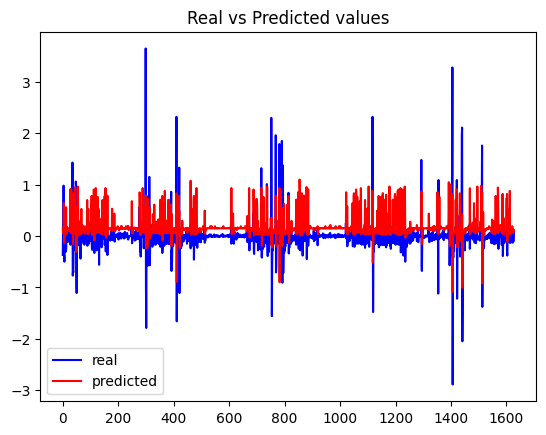

In [8]:
draw_true_predict(Y_test, pred)

RandomForestRegressor


MSE: 0.09059228766432163, MAPE: 16830031723113.613, R2: 0.08713359357994144


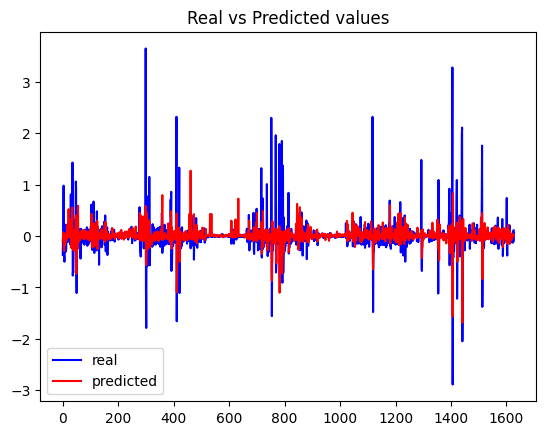

In [9]:
from sklearn.ensemble import RandomForestRegressor
X  = np.array(X)
# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)

# Initialize the estimator
estimator = RandomForestRegressor()

# Fit the data
estimator.fit(X_train, Y_train)

# Make predictions
pred = estimator.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

      var1(t-3)  var1(t-2)  var1(t-1)
3          0.00       0.12       0.17
4          0.12       0.17      -0.27
5          0.17      -0.27       0.04
6         -0.27       0.04      -0.09
7          0.04      -0.09      -0.02
...         ...        ...        ...
8212      -0.03      -0.05       0.02
8213      -0.05       0.02      -0.01
8214       0.02      -0.01      -0.13
8215      -0.01      -0.13       0.09
8216      -0.13       0.09      -0.11

[8134 rows x 3 columns] 3      -0.27
4       0.04
5      -0.09
6      -0.02
7       0.06
        ... 
8212   -0.01
8213   -0.13
8214    0.09
8215   -0.11
8216    0.11
Name: var1(t), Length: 8134, dtype: float64


C:\Users\phuoc\AppData\Local\Temp\ipykernel_28584\1610778839.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train_scaled, Y_train_scaled)


MSE: 0.09086297814903078, MAPE: 16277642506054.51, R2: 0.0844059414099888


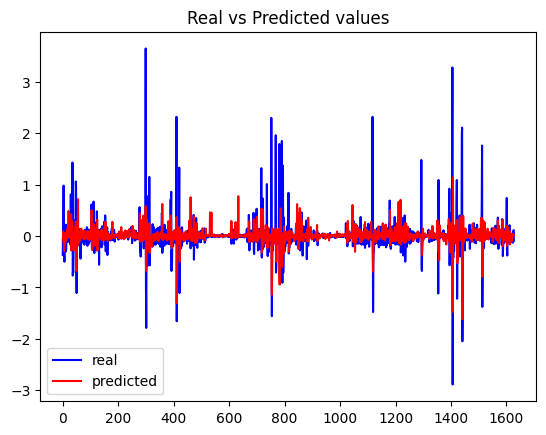

In [10]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X, Y = data[['var1(t-3)', 'var1(t-2)', 'var1(t-1)']], data['var1(t)']
print(X, Y)
X = X.values
Y = Y.values

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)
Y_train = np.reshape(Y_train, (-1, 1))
Y_test = np.reshape(Y_test, (-1, 1))

scaler_feature = StandardScaler()
scaler_feature.fit(X_train)
X_train_scaled = scaler_feature.transform(X_train)
X_test_scaled = scaler_feature.transform(X_test)

scaler_label = StandardScaler()
scaler_label.fit(Y_train)
Y_train_scaled = scaler_label.transform(Y_train)
Y_test_scaled = scaler_label.transform(Y_test)


# Initialize the estimator
estimator = RandomForestRegressor()

# Fit the data
estimator.fit(X_train_scaled, Y_train_scaled)

# Make predictions
y_pred = estimator.predict(X_test_scaled)
y_pred_unscaled = scaler_label.inverse_transform(np.reshape(y_pred, (-1, 1)))

# Calculate metrics
calculate_metrics(Y_test, y_pred_unscaled)

draw_true_predict(Y_test, y_pred_unscaled)

MSE: 1.0776049842425364, MAPE: 23.259183868989386, R2: 0.08693293064210983


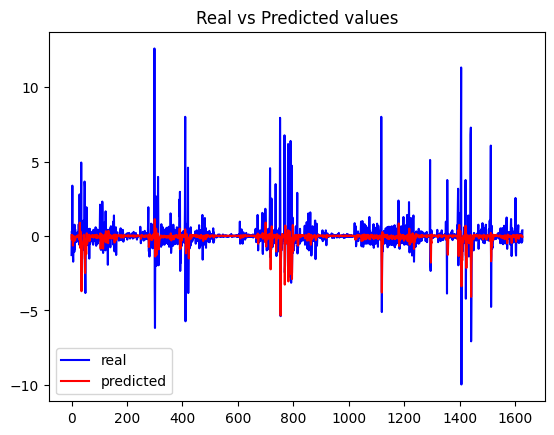

In [11]:
from sklearn.preprocessing import scale
from sklearn.svm import SVR

x = scale(X)
y = scale(Y)

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=0)

# Initialize the estimator
estimator = rfr = SVR(C=10, epsilon=0.1)

# Fit the data
estimator.fit(X_train, Y_train)

# Make predictions
pred = estimator.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

GridSearchCV

In [12]:
## Hyper-parameter tuning using GridSearchCV

from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

x = scale(X)
y = scale(Y)

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=0)

# defining parameter range
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.1, 0.2, 0.3, 0.5, 1.0],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# defining the gridsearchCV object
grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3)

# Fit the data
grid.fit(X_train, Y_train)

# Make predictions
pred = grid.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ....C=0.1, epsilon=0.1, kernel=rbf;, score=0.061 total time=   0.9s
[CV 2/5] END ....C=0.1, epsilon=0.1, kernel=rbf;, score=0.055 total time=   0.8s
[CV 3/5] END ....C=0.1, epsilon=0.1, kernel=rbf;, score=0.057 total time=   0.8s
[CV 4/5] END ....C=0.1, epsilon=0.1, kernel=rbf;, score=0.036 total time=   1.0s
[CV 5/5] END ....C=0.1, epsilon=0.1, kernel=rbf;, score=0.028 total time=   0.9s
[CV 1/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.001 total time=   0.7s
[CV 2/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.033 total time=   0.5s
[CV 3/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.054 total time=   0.6s
[CV 4/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.023 total time=   0.8s
[CV 5/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.010 total time=   0.6s
[CV 1/5] END ...C=0.1, epsilon=0.1, kernel=poly;, score=0.007 total time=  11.2s
[CV 2/5] END ...C=0.1, epsilon=0.1, kernel=pol

MSE: 1.0764985005761452, MAPE: 27.57285114619042, R2: 0.0878704669502538


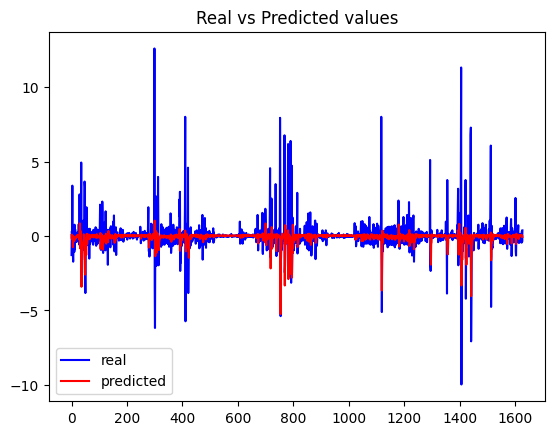

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=0)

# Make pipeline
pipe = make_pipeline(StandardScaler(), SVR(C=10, epsilon=0.2))
pipe.fit(X_train, Y_train)

# Make predictions
pred = pipe.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)


Pipeline

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


#++++++++++++++++++++++++++++++++++++
#+ create train and test sets
#++++++++++++++++++++++++++++++++++++
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=0)


#++++++++++++++++++++++++++++++++
# create the pipeline object
#++++++++++++++++++++++++++++++++
steps = [('scaler', StandardScaler()), ('SVR', SVR())]
pipeline = Pipeline(steps)


#++++++++++++++++++++++++++++++++++++++
#+ create the hyperparameter space
#++++++++++++++++++++++++++++++++++++++
parameteres = {
    'SVR__C': [0.1, 1, 10, 100, 1000],
    'SVR__epsilon': [0.1, 0.2, 0.3, 0.5, 1.0],
    'SVR__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

#++++++++++++++++++++++++++++++
#+ Grid Search Cross Validation
#++++++++++++++++++++++++++++++
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=3)

# Fit the data
grid.fit(X_train, Y_train)

# get the best parameters
print(grid.best_params_)

# Make predictions
pred = grid.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=0.061 total time=   1.1s
[CV 2/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=0.055 total time=   1.1s
[CV 3/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=0.057 total time=   1.1s
[CV 4/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=0.036 total time=   0.9s
[CV 5/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=0.028 total time=   1.1s
[CV 1/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.001 total time=   0.7s
[CV 2/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.033 total time=   0.7s
[CV 3/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.054 total time=   1.0s
[CV 4/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.023 total time=   0.8s
[CV 5/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.010 total time=   0.8s


KeyboardInterrupt: 